## Notebook for making the image used as input for the DTM generation by interpolation in QGIS

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import os
from importlib import reload
import numpy as np
import tensorflow as tf
import preprocessing_fcts as pp
import model_fcts as mod
from PIL import Image
from osgeo import gdal

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### Generating the predicted masks for the ground/object classification of the test_dataset pixels

In [3]:
pix512 = mod.load_model('seg_model', 'PixUnet',512,'sigmoid','relu')

In [4]:
test_dataset = pp.make_seg_ds(512, 'val').batch(1)

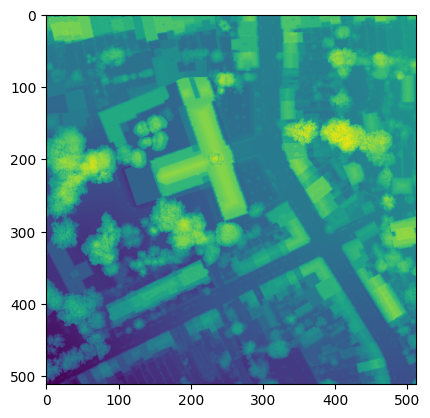

In [5]:
for i in test_dataset.take(1):
    plt.imshow(i[0][0,:,:,0])

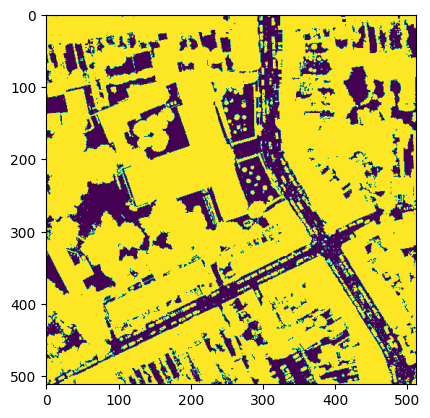

In [6]:
for i in test_dataset.take(1):
    plt.imshow(i[1][0])

In [7]:
preds = pix512.predict(test_dataset)

129/129 [==============================] - 5s 23ms/step


In [8]:
preds = preds.reshape((129,512,512))
masks = (preds<=0.5).astype('int8')

### Multiplication of the mask with DSM to obtain the pixels to use in the interpolation

In [9]:
tbs = []
res = preds[0].shape[1]
test_ds = tf.data.Dataset.load('tf_dataset/val_dataset_512')
dsms = test_ds.map(lambda x, y:x[:,:,0])

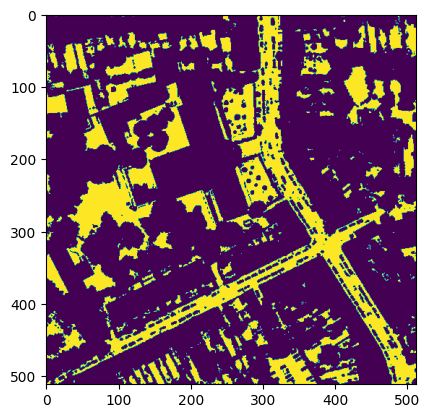

In [10]:
plt.imshow(masks[0])

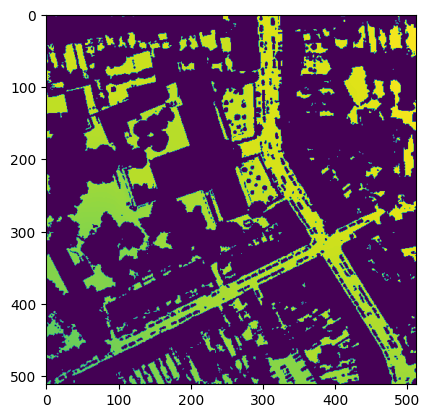

In [11]:
dsm = [i for i in dsms.take(1)][0]
plt.imshow(dsm*masks[0])

#### Saving the partial DSMs as tif image to use as input in Qgis

In [ ]:
i = 0
for dsm in dsms.as_numpy_iterator():
    arr = np.array(dsm*masks[i])
    im = Image.fromarray(arr)
    im.save('interp_dsms/a' + str(i) + '.tif')
    i += 1

### Verification that the value of 0.0 is only for non-ground pixels

In [ ]:
mins = []
for i in dsms.as_numpy_iterator():
    mins.append(np.min(i))
np.min(mins)

# Measure of the accuracy of DTMs generated on QGis with IDW interpolation

In [12]:
idw_dtms = []
for i in range(129):
    dtm = gdal.Open('interp_dsms/idw/a' + str(i) + '.tif')
    dtm = np.array(dtm.GetRasterBand(1).ReadAsArray())
    idw_dtms.append(dtm)
idw_dtms = np.array(idw_dtms)

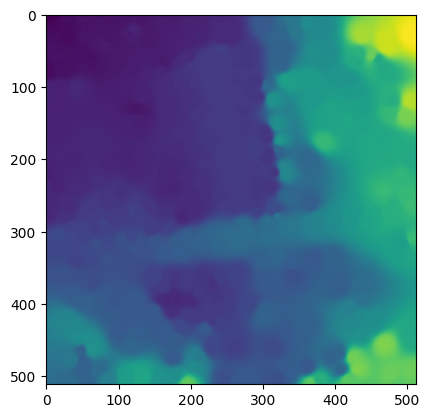

In [13]:
plt.imshow(idw_dtms[3])

## Replacing non ground points from DSM with interpolated points

In [14]:
def opposite(arr):
    return np.where((arr==0)|(arr==1), arr^1, arr)

In [15]:
dtms = []
i = 0
for dsm in dsms.as_numpy_iterator():
    dtm = idw_dtms[i] * opposite(masks[i]) + dsm * masks[i]
    i += 1
    dtms.append(dtm)

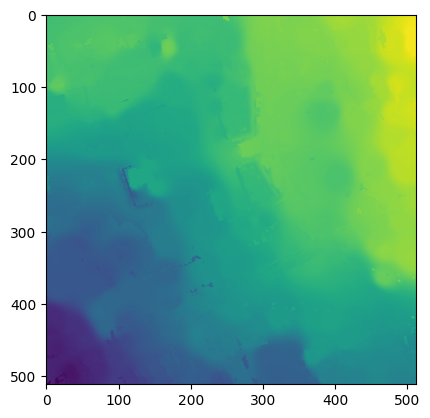

In [16]:
plt.imshow(dtms[0])

#### Measuring the RMSE and MAE of the obtained DTMs

In [17]:
raw_val_dataset = tf.data.Dataset.load('tf_dataset/val_dataset_512')
test_dtm = raw_val_dataset.map(lambda x,y:y)
res = 512
    
ssum = 0
ssum_L1 = 0
n = res**2
N = 129
i = 0
for j in test_dtm.as_numpy_iterator():
    dif = np.sum((dtms[i] - j)**2)
    dif_L1 = np.sum(tf.abs((dtms[i] - j)))
    ssum += dif
    ssum_L1 += dif_L1
    i += 1

print(np.sqrt(ssum/(i*n)))
print(ssum_L1/(i*n))

1.9173628173446695
0.5840153490272604
